# Brain Tumor Detection and Classification using Convulational Neural Network

# Overview
This project aims to build a Convolutional Neural Network (CNN) model for image classification using the Keras deep learning library with TensorFlow backend. The model is designed to classify images into multiple categories or classes based on their visual features.

# Contents
The notebook has the follwing contents:
### Importing required libraries and dataset
### Visualizing and analyzing the data
### Building and training the Neural Network
### Analyzing the results


# Importing required libraries and dataset

In [1]:
import os
import itertools
from PIL import Image

# data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

2024-02-10 10:43:04.453388: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 10:43:04.453522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 10:43:04.588802: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Generate data paths with labels
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [3]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)
test_df.head(10)

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
5,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
6,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
7,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
8,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
9,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


In [4]:
train_df, valid_df = train_test_split(train_df,  train_size= 0.8, shuffle= True, random_state=69)
print(train_df.head())
print(valid_df.head())
print(test_df.head())

                                              filepaths     labels
5516  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5187  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
102   /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4754  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
1100  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
                                              filepaths      labels
5407  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
5370  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
859   /kaggle/input/brain-tumor-mri-dataset/Training...   pituitary
4144  /kaggle/input/brain-tumor-mri-dataset/Training...  meningioma
3427  /kaggle/input/brain-tumor-mri-dataset/Training...  meningioma
                                           filepaths     labels
0  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitar

In [5]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


# Visualizing and Analyzing the dataset

## Frequency Distributoin of Samples 

In [6]:
import pandas as pd

# Assuming train_df, valid_df, and test_df are your dataframes

# Concatenate the dataframes to create a combined dataframe
combined_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

# Count the frequency of each label
label_counts = combined_df['labels'].value_counts()

# Print the frequency distribution
print("Frequency Distribution of Samples:")
print(label_counts)


Frequency Distribution of Samples:
labels
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64


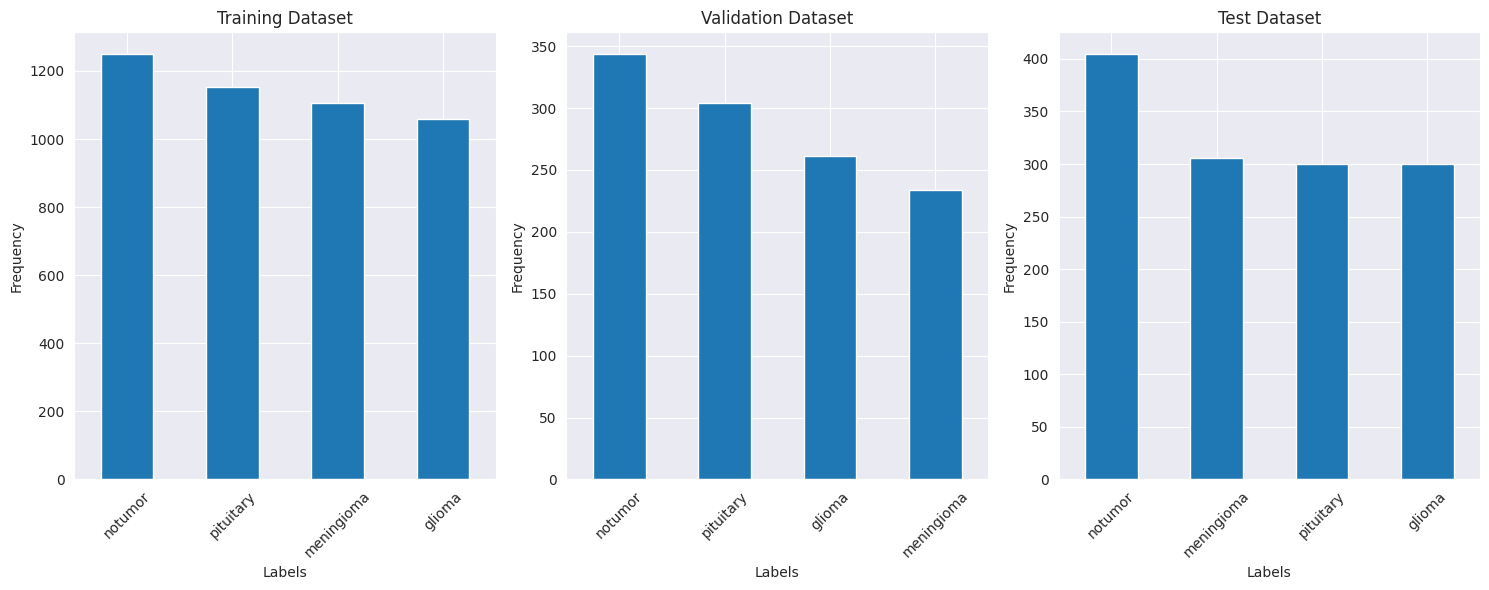

In [7]:
import matplotlib.pyplot as plt

# Calculate frequency distribution for each dataset
train_label_counts = train_df['labels'].value_counts()
valid_label_counts = valid_df['labels'].value_counts()
test_label_counts = test_df['labels'].value_counts()

# Plot frequency distribution for each dataset
plt.figure(figsize=(15, 6))

# Training dataset
plt.subplot(1, 3, 1)
train_label_counts.plot(kind='bar')
plt.title('Training Dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Validation dataset
plt.subplot(1, 3, 2)
valid_label_counts.plot(kind='bar')
plt.title('Validation Dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Test dataset
plt.subplot(1, 3, 3)
test_label_counts.plot(kind='bar')
plt.title('Test Dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Viewing some samples from the dataset

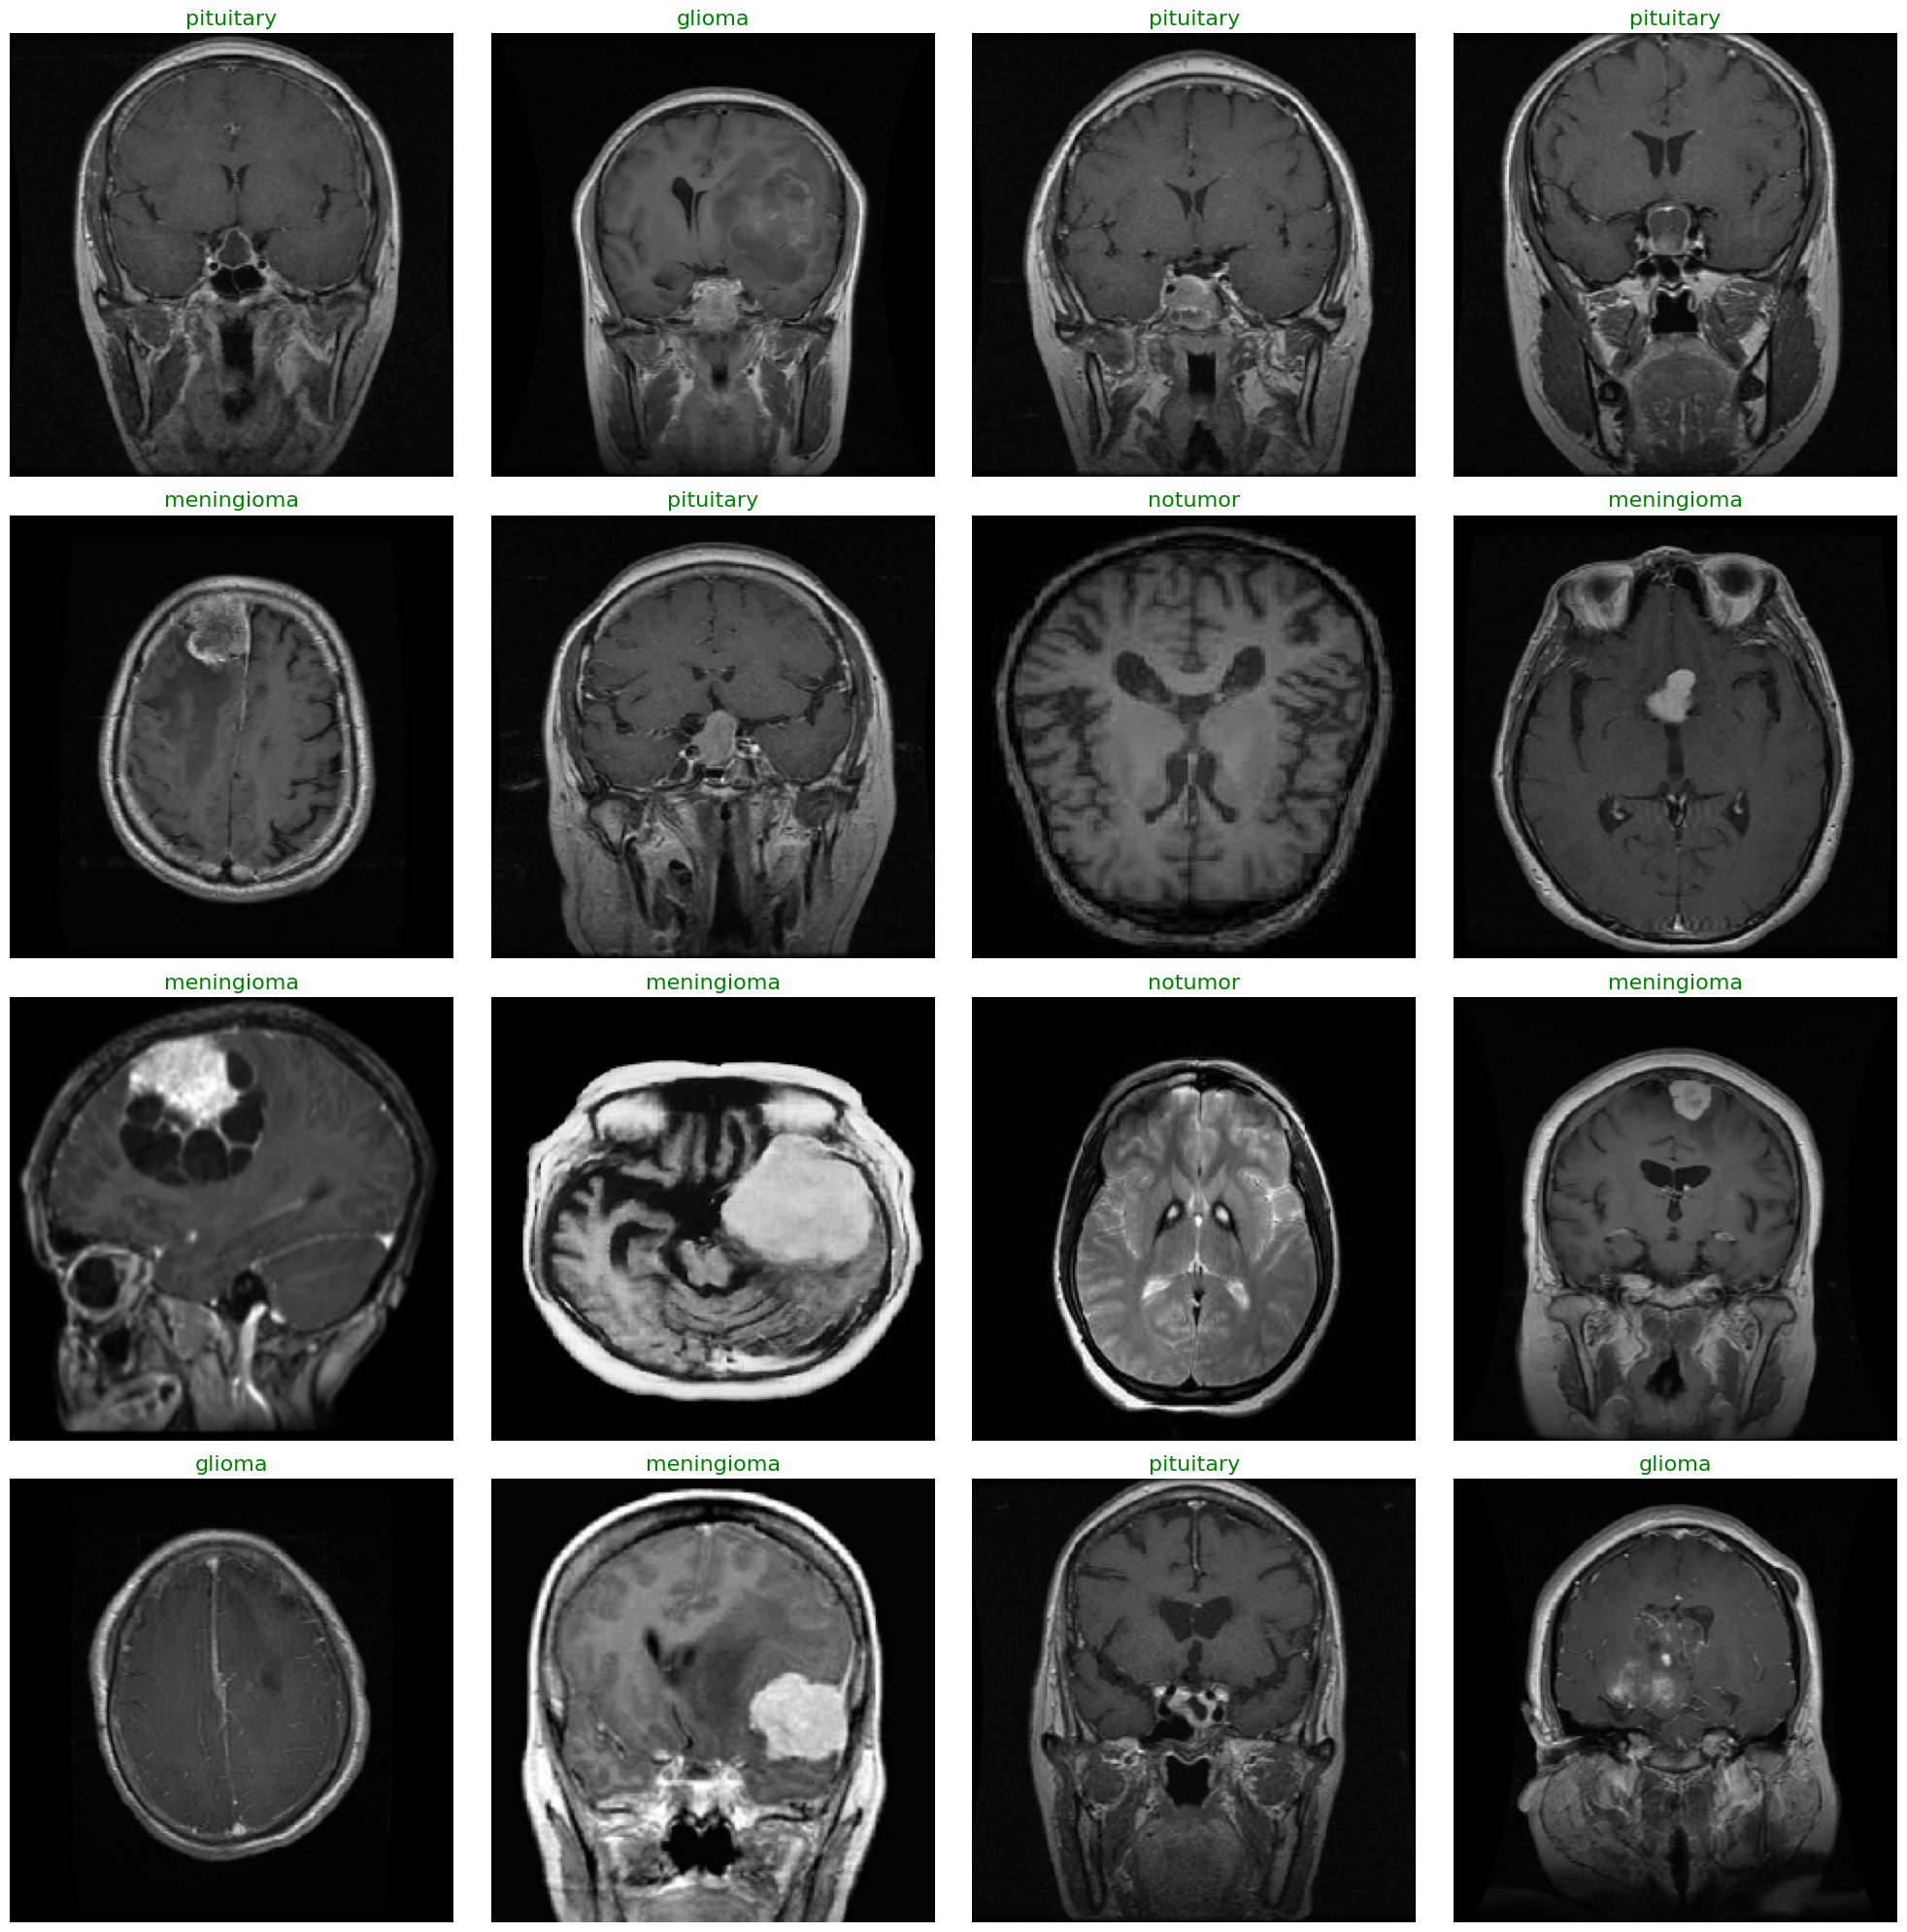

In [8]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'green', fontsize=16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Building and training  model

## Model Architecture

This model architecture is a Convolutional Neural Network (CNN) designed for image classification tasks. Here's a summary and explanation of the architecture:

1. **Input Layer**: 
   - Input images are expected to have a size of 224x224 pixels with 3 color channels (RGB).

2. **Convolutional Layers**:
   - The model starts with a series of convolutional layers (`Conv2D`) with 64 filters, each having a kernel size of (3, 3), using the ReLU activation function.
   - This pattern repeats, increasing the number of filters.
   - Each convolutional layer uses "same" padding to ensure the output feature maps have the same spatial dimensions as the input.
   - After every two convolutional layers, a max-pooling layer (`MaxPooling2D`) with a pool size of (2, 2) is added to reduce spatial dimensions and extract dominant features.

3. **Flatten Layer**:
   - The output feature maps from the last convolutional layer are flattened into a one-dimensional array.

4. **Dense Layers**:
   - A series of fully connected dense layers (`Dense`) follows the flatten layer.
   - The first dense layer has 256 units with ReLU activation, followed by another dense layer with 64 units and ReLU activation.
   - The final dense layer has a number of units equal to the total number of classes in the dataset (determined by `class_count`) and uses the softmax activation function to output class probabilities.

5. **Compilation**:
   - The model is compiled using the Adamax optimizer with a learning rate of 0.001.
   - Categorical cross-entropy is used as the loss function since this is a multi-class classification problem.
   - Accuracy is chosen as the evaluation metric.


In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adamax

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
     Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),    
    
    
    Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

optimizer = Adamax()
model.compile(optimizer=optimizer, loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [10]:
epochs = 30 # number of all epochs in training
optimizer.learning_rate.assign(0.0001)
history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/30


I0000 00:00:1707561815.195527      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


286/286 [==============================] - 62s 170ms/step - loss: 0.7976 - accuracy: 0.6522 - val_loss: 0.6045 - val_accuracy: 0.8049
Epoch 2/30
286/286 [==============================] - 40s 139ms/step - loss: 0.5089 - accuracy: 0.8192 - val_loss: 0.4781 - val_accuracy: 0.8408
Epoch 3/30
286/286 [==============================] - 40s 139ms/step - loss: 0.3526 - accuracy: 0.8842 - val_loss: 0.7221 - val_accuracy: 0.8793
Epoch 4/30
286/286 [==============================] - 40s 139ms/step - loss: 0.2329 - accuracy: 0.9223 - val_loss: 0.3461 - val_accuracy: 0.8915
Epoch 5/30
286/286 [==============================] - 40s 139ms/step - loss: 0.2500 - accuracy: 0.9413 - val_loss: 0.6548 - val_accuracy: 0.9055
Epoch 6/30
286/286 [==============================] - 40s 139ms/step - loss: 0.2353 - accuracy: 0.9569 - val_loss: 0.6557 - val_accuracy: 0.9309
Epoch 7/30
286/286 [==============================] - 40s 139ms/step - loss: 0.1294 - accuracy: 0.9700 - val_loss: 0.9369 - val_accuracy: 0.9

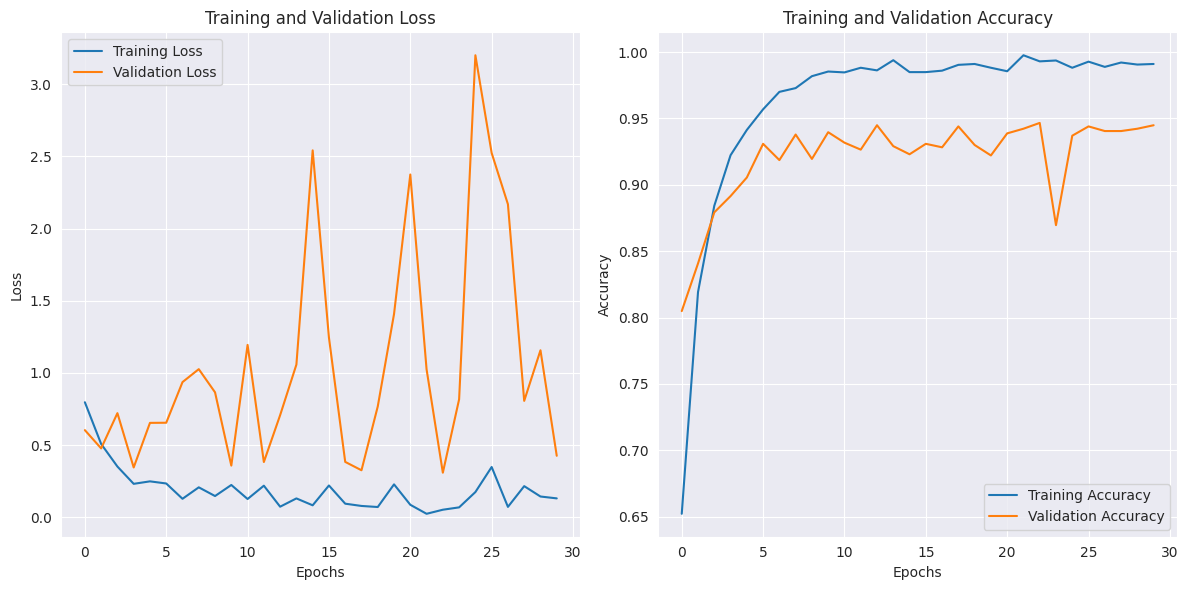

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot training history
def plot_training_history(history):
    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot training history
plot_training_history(history)



In [12]:
epochs = 50 # number of all epochs in training
optimizer.learning_rate.assign(0.00001)
history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/50
286/286 [==============================] - 39s 138ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.4307 - val_accuracy: 0.9458
Epoch 2/50
286/286 [==============================] - 39s 138ms/step - loss: 0.0432 - accuracy: 0.9996 - val_loss: 1.4696 - val_accuracy: 0.9423
Epoch 3/50
286/286 [==============================] - 39s 138ms/step - loss: 0.0640 - accuracy: 0.9989 - val_loss: 3.4898 - val_accuracy: 0.9396
Epoch 4/50
286/286 [==============================] - 40s 138ms/step - loss: 0.0580 - accuracy: 0.9987 - val_loss: 1.0727 - val_accuracy: 0.9414
Epoch 5/50
286/286 [==============================] - 40s 138ms/step - loss: 0.0824 - accuracy: 0.9991 - val_loss: 1.3246 - val_accuracy: 0.9449
Epoch 6/50
286/286 [==============================] - 39s 137ms/step - loss: 0.0178 - accuracy: 0.9991 - val_loss: 0.6412 - val_accuracy: 0.9423
Epoch 7/50
286/286 [==============================] - 39s 137ms/step - loss: 0.0258 - accuracy: 0.9996 - val_loss: 0.4824 - val_ac

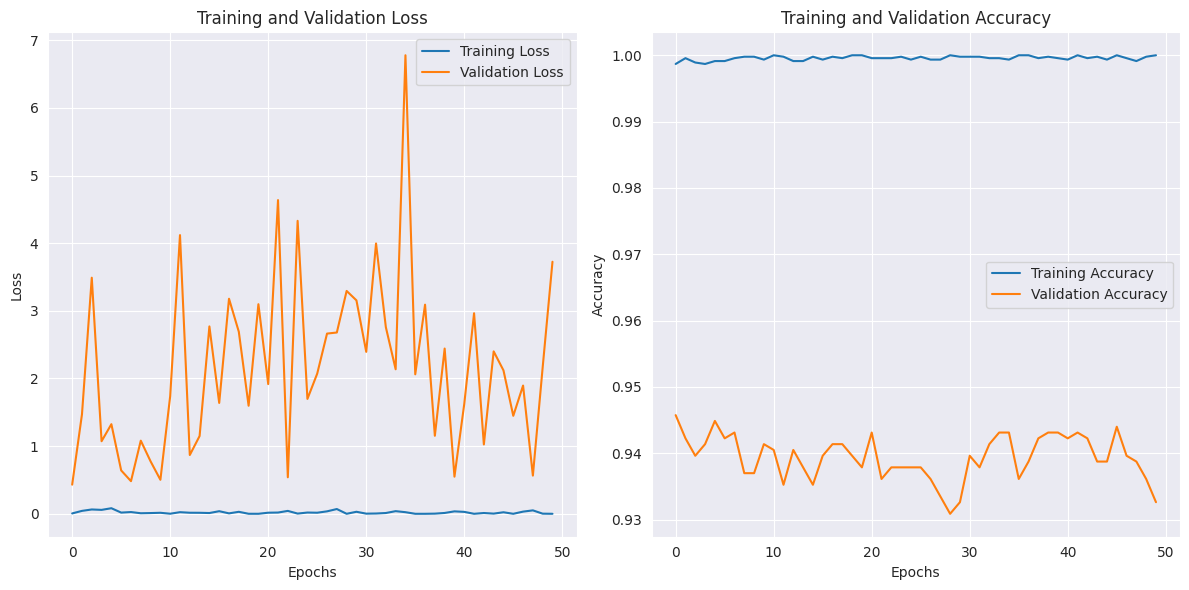

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot training history
def plot_training_history(history):
    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot training history
plot_training_history(history)



In [14]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

82/82 [==============================] - 11s 131ms/step - loss: 0.4005 - accuracy: 0.9558
Train Loss:  8.637901919428259e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.8615570664405823
Validation Accuracy:  0.93438321352005
--------------------
Test Loss:  0.4004665017127991
Test Accuracy:  0.9557589888572693


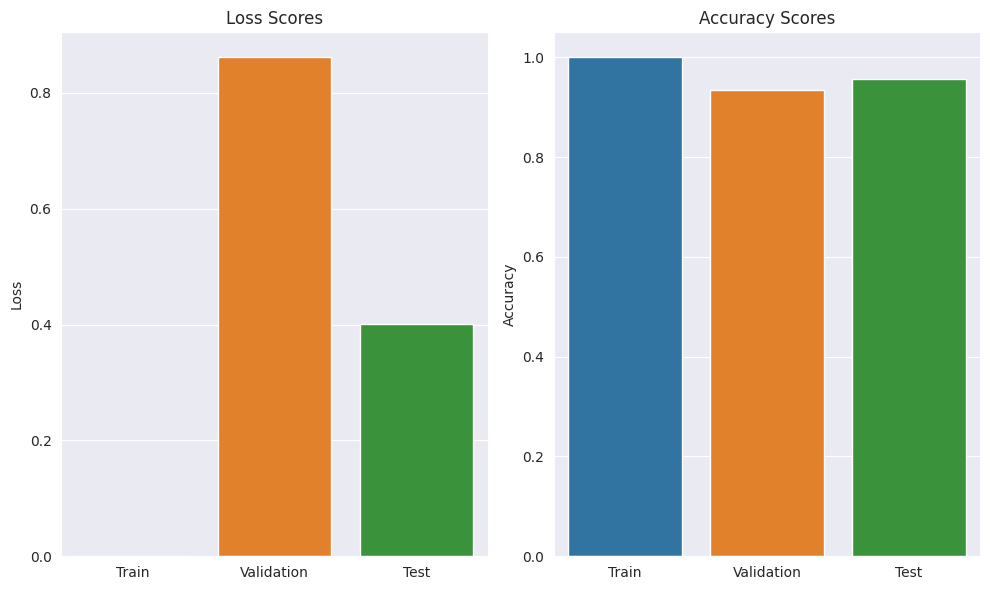

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
loss_values = [train_score[0], valid_score[0], test_score[0]]
accuracy_values = [train_score[1], valid_score[1], test_score[1]]
data_labels = ['Train', 'Validation', 'Test']

# Plot
plt.figure(figsize=(10, 6))

# Loss
plt.subplot(1, 2, 1)
sns.barplot(x=data_labels, y=loss_values)
plt.title('Loss Scores')
plt.ylabel('Loss')

# Accuracy
plt.subplot(1, 2, 2)
sns.barplot(x=data_labels, y=accuracy_values)
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [16]:
preds = model.predict_generator(test_gen)  # [0.00001, 95.12312, 0.0021, 3.12313]
y_pred = np.argmax(preds, axis=1)

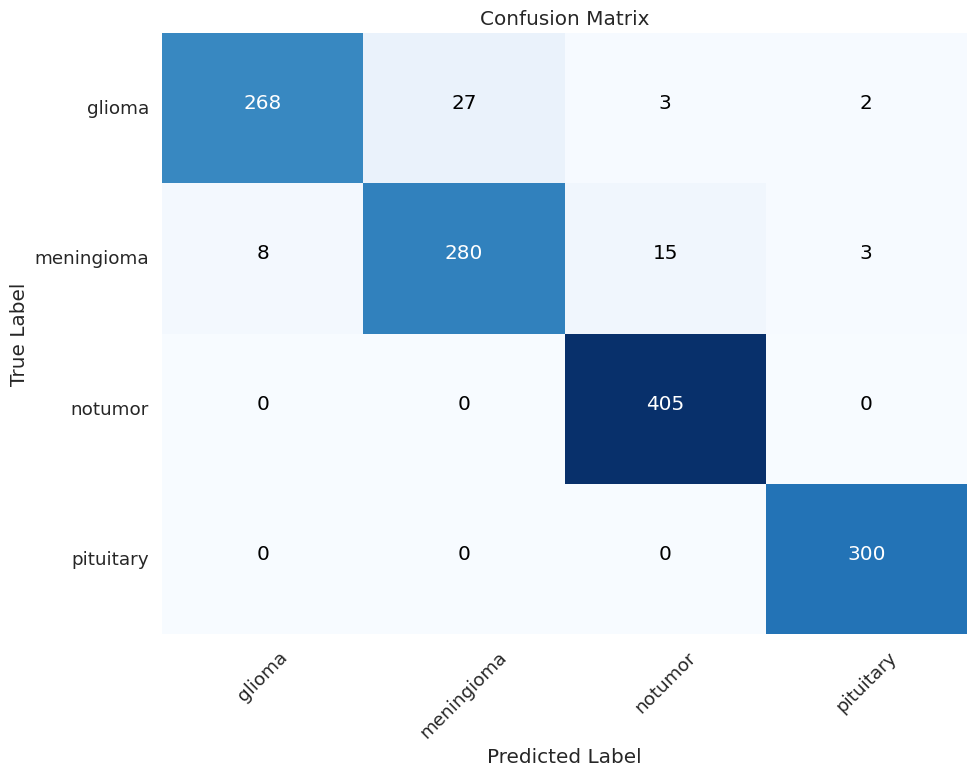

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

# Given data
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Set font scale

# Create heatmap
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(classes)) + 0.5, classes, rotation=45)
plt.yticks(np.arange(len(classes)) + 0.5, classes, rotation=0)

# Add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()


## Visualizing Classification Metrics

In [18]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.97      0.89      0.93       300
  meningioma       0.91      0.92      0.91       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



### Classification metrics as heatmap

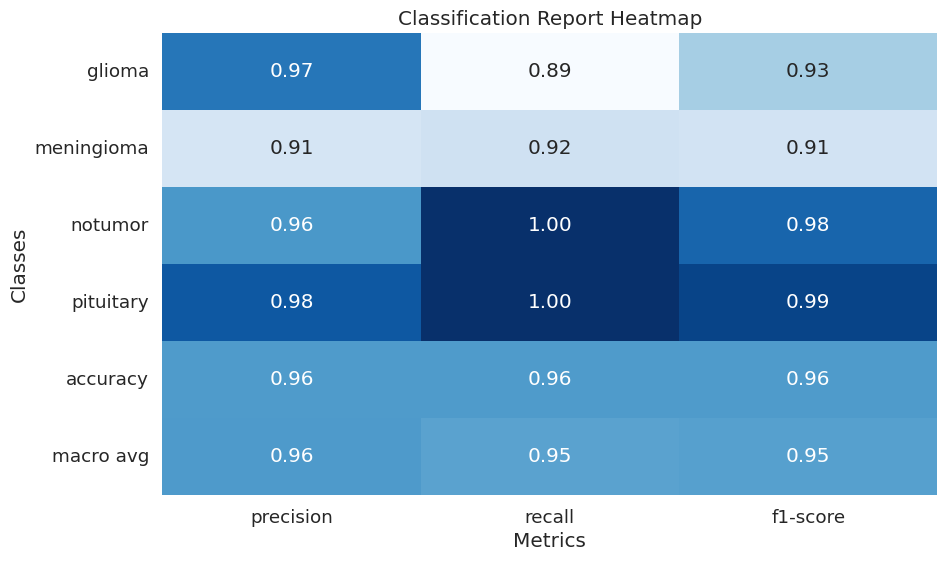

In [19]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Generate classification report
report = classification_report(test_gen.classes, y_pred, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :3], annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()




### Classification metrics barplot

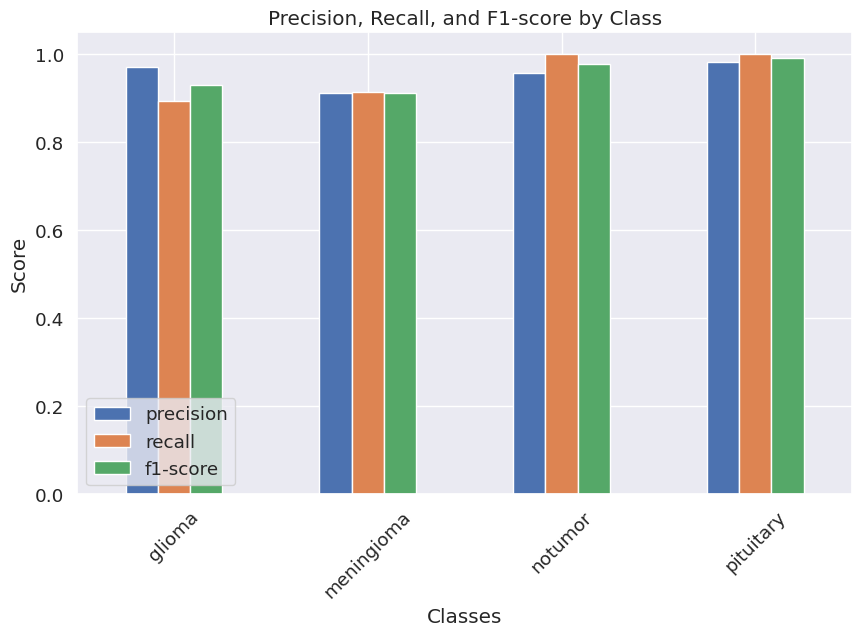

In [20]:
# Plot as bar plots
report_df.iloc[:-3, :3].plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, and F1-score by Class')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower left')
plt.show()

## Saving the trained model

In [21]:
model.save('Brain Tumors.h5')
model_path = "/kaggle/working/Brain Tumors.h5"
print(f"Model Saved to: {model_path}")

Model Saved to: /kaggle/working/Brain Tumors.h5
